<a href="https://colab.research.google.com/github/jcdumlao14/ESS11DataAnalysis/blob/main/Counterfactual_Causal_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Counterfactual  Causal Machine Learning Analysis (Average Treatment Effect (ATE) +  Heterogeneous Treatment Effect (HTE))**

# **I. Goal**
- Investigate **"What-if"** scenarios: How would **predicted Cardiovascular Disease (CVD)** risk change in European populations if specific risk factor profiles were altered (target changes)?

# **II. Data Preparation**

- A. **Outcome Variable (Y)**: Binary CVD Indicator
   - Primary Variables (to create CVD outcome):
     - **hltprhc** : Health problems, last 12 months: heart or circulation problem
     - **hltprhb** : Health problems, last 12 months: high blood pressure
     - **hltphhc** : Health problems, hampered, last 12 month: heart or circulation problem
     - **hltphhb** : Health problems, hampered, last 12 month: high blood pressure

- B. **Treatment/Target Change (W)**: Scenario-Specific.
   - **Scenario 1: Low Mortality Country Lifestyle**:
     - **Objective**: To model the effect of shifting a population to a lifestyle profile similar to that of a low-CVD mortality country.
     - **Method**: You reweight or replace X to match target distribution by variables.
       - **Target Change Variables**: (The "W" set to be altered to define the scenario.)
          - **cgtsmok**: Cigarette smoking behaviour
          - **alcfreq**: How often drink alcohol
          - **etfruit**: How often eat fruit, excluding drinking juice
          - **eatveg**: How often eat vegetables or salad, excluding potatoes
          - **dosprt**: Do sports or other physical activity, how many of last 7 days
          - **slprl**: sleep was restless,how often past week
          - **BMI**: Body Mass Index (calculated from height and weight).

   - **Scenario 2: Changing Specific Risk Factors**
      - **Objective**: To only affect smoking (e.g. cgtsmok to target a lower prevalence of heavy smoking)
- C. **Covariates (X)**: Control Variables
   - **Demographics**:
      - **agea**: Age of respondent, calculated
      - **gndr**: Gender
      - **edulvlb**: Highest level of education achieved (Handle carefully; ordinal, country-specific. See previous notes)
      - **hinctnta**: Household's total net income, all sources (Handle with care; lots of missing data likely; consider transforming (e.g. log) and imputation)
      - **mainact**: Main activity last 7 days (employment).
   - **cntry**: Country
   - **imsmetn,imdfetn,impcntr**:  Migration and Socio-economic Variables imsmetn.
   - **Weights** (Crucial to include for representativeness):
      - **dweight**: Design weight
      - **pspwght**: Post-stratification weight including design weight
     - **pweight**: Population size weight (if using, must be combined with dweight or pspwght)

 - **Region**:region

**III. Methods**(at least two)
- **Primary**: Causal Forest (Python, econml/causalml. Use CausalForestDML).
- **Robustness Check**: TMLE or **Double Machine Learning** (DML) - check that the result is the same in general to be robust.

*References*: EconML- **CausalForestDML** - https://www.pywhy.org/EconML/_autosummary/econml.dml.CausalForestDML.html

**IV. Estimation Tasks**
- **ATE**: Average Treatment Effect (of the specified intervention) with 90% and 95% Confidence Intervals.
- **ATT**: Average Treatment Effect on the Treated (if the intervention is only applied to a subset) with 90% and 95% Confidence Intervals.
- **HTE/CATE**: Heterogeneous Treatment Effects / Conditional Average Treatment Effect by Subgroups:
  - **Age Groups** (e.g., 18-29, 30-49, 50+).
  - **gndr**: Gender (Binary)

  - **Education** (Low, Medium, High - based on edulvlb or similar).
  - **Region** (e.g., East, West, North, South Europe - Requires creating a region variable based on cntry).

*References* **CATE**: https://www.pywhy.org/EconML/reference.html#instrumental-variable-cate-estimators

**V. Model Validation & Sensitivity**
- **A. Model Specification**: Vary tree depth and regularization parameters in the causal forest to assess stability.
- **B. Alternative Target Distributions**: Try different scenarios in "W." Examples:
   - Only change cgtsmok (smoking behavior) to a target distribution.
   - Change both cgtsmok and BMI to target distributions.
- **C. E-value for Unmeasured Confounding**: (For interpretation).
- **D. Weighted vs. Unweighted Analyses:**

In [ ]:
!pip install econml

Data loaded. N = 46162 CVD prevalence = 0.4296
econml is available. You can run CausalForestDML below for advanced estimation (honest forests).
Scenario 'baseline' took 0.01 seconds
Saved regression plot to /content/ess_causal_outputs/regression_plot_bmi_to_25.png
Scenario: bmi_to_25
  Mean Squared Error: 0.0255
  R-squared: 0.5559
Scenario 'bmi_to_25' took 21.33 seconds
Saved regression plot to /content/ess_causal_outputs/regression_plot_reduce_heavy_smoking.png
Scenario: reduce_heavy_smoking
  Mean Squared Error: 0.0528
  R-squared: 0.0591
Scenario 'reduce_heavy_smoking' took 15.23 seconds
Saved regression plot to /content/ess_causal_outputs/regression_plot_bmi25_and_reduce_smoke.png
Scenario: bmi25_and_reduce_smoke
  Mean Squared Error: 0.0255
  R-squared: 0.5559
Scenario 'bmi25_and_reduce_smoke' took 15.83 seconds
Saved regression plot to /content/ess_causal_outputs/regression_plot_low_mortality_lifestyle.png
Scenario: low_mortality_lifestyle
  Mean Squared Error: 0.0317
  R-square

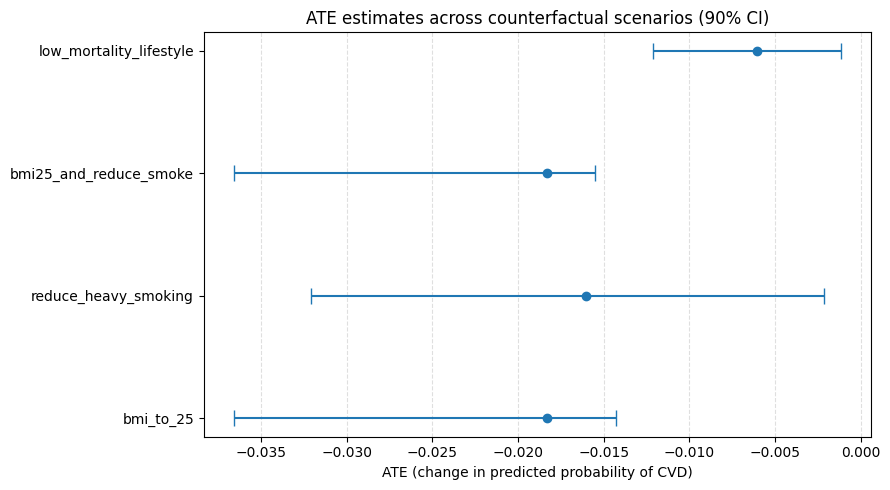

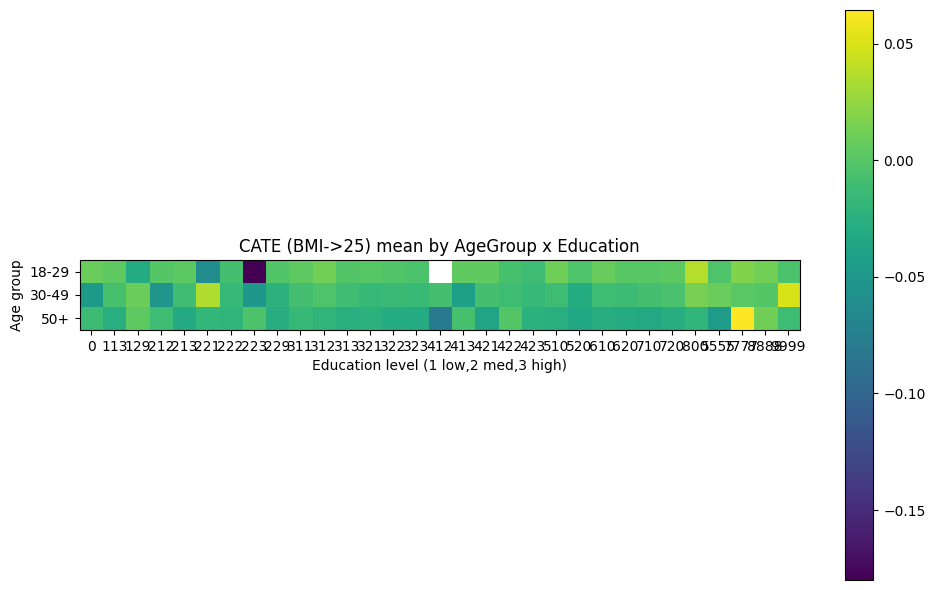

In [ ]:
import os
import warnings
#warnings.filterwarnings("ignore")  # Remove during debugging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import time # Import time module
from sklearn.metrics import mean_squared_error, r2_score

# Set random seed for reproducibility
np.random.seed(123)

# ---------
# Settings
# ----------

CSV_PATH = '/content/ESS11.csv'

# Output directory
OUT_DIR = '/content/ess_causal_outputs'
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, 'tables'), exist_ok=True)



# --- ADJUST THESE VALUES AS NEEDED ---
N_BOOTSTRAP = 5
RF_TREES = 50
RF_TREES_SMALL = 25


N_JOBS = -1       # Use all cores

# ----------------------
# European region mapping
# ----------------------
REGION_MAP = {
    'NO':'North','SE':'North','DK':'North','FI':'North','IS':'North','GB':'North','IE':'North',
    'FR':'West','BE':'West','NL':'West','LU':'West','DE':'West','AT':'West',
    'ES':'South','PT':'South','IT':'South','GR':'South','CY':'South','MT':'South',
    'PL':'East','CZ':'East','SK':'East','HU':'East','RO':'East','BG':'East','SI':'East','HR':'East',
    # add more if needed
}

def get_region(code):
    if pd.isna(code):
        return 'Unknown'
    c = str(code).strip().upper()
    return REGION_MAP.get(c, 'Unknown')

# ----------------------
# Helpers: loading and preprocessing
# ----------------------

def load_and_prepare(csv_path=None, verbose=True):
    """Load ESS11-like CSV if provided, else simulate demo data. Returns prepared DataFrame.
    The function attempts to build the outcome CVD from `hltprhc` (primary) or `hltphhc`.
    """
    if csv_path is None or not os.path.exists(csv_path):
        if verbose:
            print('CSV_PATH not provided or file not found. Running on simulated demo data.')
        return simulate_demo()

    usecols = None
    # recommended columns. If your CSV has different names, adjust below.
    key_cols = ['idno','cntry','dweight','pspwght','weighta','height','mainact','slprl',
                'etfruit','eatveg','dosprt','cgtsmok','alcfreq','alcwkdy','alcwknd','edulvlb','hinctnta','agea','gndr', "hltprhc", "hltprhb", "hltphhc", "hltphhb"] # add new columns
    try:
        df = pd.read_csv(csv_path, usecols=lambda c: True if c in key_cols else False, low_memory=False)
    except Exception as e:
        print('Error reading CSV; falling back to full read. Error:', e)
        df = pd.read_csv(csv_path, low_memory=False)

    # Ensure columns exist; create missing columns with NA
    for c in key_cols:
        if c not in df.columns:
            df[c] = np.nan

    # Convert columns to numeric, handling errors
    cols_to_convert = ["hltprhc", "hltprhb", "hltphhc", "hltphhb"]
    for col in cols_to_convert:
        df[col] = pd.to_numeric(df[col], errors='coerce') # Convert to numeric and coerce errors to NaN

    # Impute missing values
    df[cols_to_convert] = df[cols_to_convert].fillna(0)

    # Add the new CVD column
    df["CVD"] = df[["hltprhc", "hltprhb", "hltphhc", "hltphhb"]].sum(axis=1)

    # Convert common truthy values to 1 else 0; user may need to adapt mapping
    def map_binary(x):
        if pd.isna(x):
            return np.nan
        s = str(x).strip().lower()
        if s in ['1','yes','y','true','t','a','b','c']:
            return 1
        # numeric >=1 often indicates presence; adapt depending on coding
        try:
            vx = float(s)
            return 1 if vx >= 1 else 0
        except Exception:
            return 0

    # BMI calculation
    df['height_m'] = df['height'] / 100.0
    df['BMI'] = df['weighta'] / (df['height_m'] ** 2)

    # Smoking: ensure coded categories 0-3; if strings, try to map;
    # Create heavy smoking indicator
    try:
        df['cgtsmok'] = pd.to_numeric(df['cgtsmok'], errors='coerce')
    except Exception:
        pass
    df['smoke_heavy'] = (df['cgtsmok'] == 3).astype(int)

    # Map region
    df['cntry'] = df['cntry'].astype(str)
    df['region'] = df['cntry'].apply(get_region)

    # Clean age & gender & education
    df['agea'] = pd.to_numeric(df['agea'], errors='coerce')
    df['gndr'] = pd.to_numeric(df['gndr'], errors='coerce')
    df['edulvlb'] = pd.to_numeric(df['edulvlb'], errors='coerce')

    # Keep only rows with essential fields
    essential = ['CVD','BMI','agea','gndr','edulvlb']
    df = df.dropna(subset=essential)

    return df.reset_index(drop=True)


def simulate_demo(n=3000):
    """Simulate an ESS-like dataset for demonstrations and development/testing.
    Returns DataFrame with necessary columns.
    """
    rng = np.random.RandomState(123)
    countries = list(REGION_MAP.keys()) + ['EE','LV','LT','CH','RS','BA']
    df = pd.DataFrame({
        'idno': np.arange(n),
        'cntry': rng.choice(countries, size=n),
        'agea': rng.randint(18, 90, size=n),
        'gndr': rng.choice([1,2], size=n, p=[0.48,0.52]),
        'edulvlb': rng.choice([1,2,3], size=n, p=[0.3,0.45,0.25]),
    })
    df['weighta'] = np.clip(rng.normal(78, 15, size=n), 45, 160)
    df['height'] = np.clip(rng.normal(170, 9, size=n), 140, 210)
    df['height_m'] = df['height'] / 100.0
    df['BMI'] = (df['weighta'] / (df['height_m']**2)).round(2)
    # smoking distribution varies by region
    def sample_smoke(r):
        p_map = { 'North':[0.50,0.20,0.20,0.10],'West':[0.45,0.20,0.25,0.10],'South':[0.40,0.20,0.25,0.15],'East':[0.35,0.20,0.25,0.20] }
        p = p_map.get(REGION_MAP.get(r,'West'), [0.45,0.20,0.20,0.15])
        return rng.choice([0,1,2,3], p=p)
    df['region'] = df['cntry'].apply(lambda c: get_region(c))
    df['cgtsmok'] = df['region'].apply(sample_smoke)
    df['etfruit'] = rng.randint(0,8,size=n)
    df['eatveg'] = rng.randint(0,8,size=n)
    df['dosprt'] = rng.randint(0,8,size=n)
    df['alcfreq'] = rng.choice([0,1,2,3], size=n, p=[0.25,0.35,0.30,0.10])
    df['alcwkdy'] = rng.randint(0,4,size=n)
    df['alcwknd'] = rng.randint(0,4,size=n)
    df['hinctnta'] = np.clip(rng.lognormal(10, 0.5, size=n), 500, 200000)
    df['dweight'] = rng.uniform(0.5, 2.5, size=n)
    df['pspwght'] = df['dweight'] * rng.uniform(0.8, 1.2, size=n)
    # generate CVD probability
    logit = (
        -6.5
        + 0.05 * df['agea']
        + 0.6 * (df['cgtsmok'] == 3).astype(int)
        + 0.02 * (df['BMI'] - 25).clip(-10, 20)
        - 0.06 * df['dosprt']
        + 0.15 * (df['gndr'] == 1).astype(int)
        - 0.12 * (df['edulvlb'] == 3).astype(int)
    )
    p = 1 / (1 + np.exp(-logit))
    df['CVD'] = (rng.rand(n) < p).astype(int)
    df['smoke_heavy'] = (df['cgtsmok'] == 3).astype(int)
    return df

# ----------------------
# Scenario definitions
# ----------------------

def scenario_bmi_target(df_in, target_bmi=25.0):
    df2 = df_in.copy()
    df2['BMI'] = target_bmi
    return df2


def scenario_reduce_smoking(df_in, heavy_prob_target=0.05, random_state=123):
    df2 = df_in.copy()
    cur = df2['smoke_heavy'].mean()
    if heavy_prob_target >= cur or cur == 0:
        return df2
    reduce_fraction = (cur - heavy_prob_target) / cur
    heavy_idx = df2[df2['smoke_heavy'] == 1].index
    rng = np.random.RandomState(random_state)
    n_change = int(reduce_fraction * len(heavy_idx))
    if n_change <= 0:
        return df2
    change_idx = rng.choice(heavy_idx, size=n_change, replace=False)
    df2.loc[change_idx, 'cgtsmok'] = 2
    df2.loc[change_idx, 'smoke_heavy'] = 0
    return df2


def scenario_low_mortality_lifestyle(df_in):
    df2 = df_in.copy()
    df2 = scenario_reduce_smoking(df2, heavy_prob_target=0.05)
    df2['etfruit'] = np.minimum(7, df2['etfruit'] + np.random.randint(1,3,size=len(df2)))
    df2['eatveg'] = np.minimum(7, df2['eatveg'] + np.random.randint(1,3,size=len(df2)))
    df2['dosprt'] = np.minimum(7, df2['dosprt'] + np.random.randint(1,3,size=len(df2)))
    df2['BMI'] = np.clip(df2['BMI'] - 1.2, 10, 60)
    return df2

SCENARIOS = {
    'baseline': lambda d: d.copy(),
    'bmi_to_25': lambda d: scenario_bmi_target(d, 25.0),
    'reduce_heavy_smoking': lambda d: scenario_reduce_smoking(d, heavy_prob_target=0.05),
    'bmi25_and_reduce_smoke': lambda d: scenario_reduce_smoking(scenario_bmi_target(d,25.0), heavy_prob_target=0.05),
    'low_mortality_lifestyle': lambda d: scenario_low_mortality_lifestyle(d),
}

# ----------------------
# Estimators & inference helpers
# ----------------------

def estimate_ate_by_outcome_model_replacement(df, features=None, outcome_col='CVD', target_bmi=25.0, n_boot=100):
    """Outcome model (T->continuous) replacement ATE estimator.
    Fit P(Y|X,BMI) then replace BMI->target and compute mean(pred_cf - pred_base).
    Bootstrapped refits used for CI estimation.
    """
    if features is None:
        features = ['agea','gndr','edulvlb','BMI','cgtsmok','etfruit','eatveg','dosprt','alcfreq','hinctnta','mainact', 'slprl']
    X = df[features].copy()
    X_enc = pd.get_dummies(X, columns=['gndr','edulvlb','cgtsmok','alcfreq'], drop_first=True)
    y = df[outcome_col].values

    model = RandomForestClassifier(n_estimators=RF_TREES, random_state=123, n_jobs=N_JOBS)
    model.fit(X_enc, y)
    pred_base = model.predict_proba(X_enc)[:,1]

    X_mod = X.copy(); X_mod['BMI'] = target_bmi
    X_mod_enc = pd.get_dummies(X_mod, columns=['gndr','edulvlb','cgtsmok','alcfreq'], drop_first=True)
    for c in X_enc.columns:
        if c not in X_mod_enc.columns:
            X_mod_enc[c] = 0
    X_mod_enc = X_mod_enc[X_enc.columns]
    pred_cf = model.predict_proba(X_mod_enc)[:,1]
    ate_point = (pred_cf - pred_base).mean()

    # bootstrap
    ate_boot = []
    n = len(df)
    for i in range(n_boot):
        idx = np.random.choice(n, n, replace=True)
        Xb = X_enc.iloc[idx]; yb = y[idx]
        mb = RandomForestClassifier(n_estimators=RF_TREES_SMALL, random_state=1000+i, n_jobs=N_JOBS)
        try:
            mb.fit(Xb, yb)
        except Exception:
            continue
        pred_base_b = mb.predict_proba(Xb)[:,1]
        X_mod_b = X_mod_enc.iloc[idx]
        pred_cf_b = mb.predict_proba(X_mod_b)[:,1]
        ate_boot.append((pred_cf_b - pred_base_b).mean())
    ate_boot = np.array(ate_boot)
    ate_std = np.nan if len(ate_boot) == 0 else ate_boot.std(ddof=1)
    lower_90 = np.nan if len(ate_boot) == 0 else np.percentile(ate_boot, 5)
    upper_90 = np.nan if len(ate_boot) == 0 else np.percentile(ate_boot, 95)
    lower_95 = np.nan if len(ate_boot) == 0 else np.percentile(ate_boot, 2.5)
    upper_95 = np.nan if len(ate_boot) == 0 else np.percentile(ate_boot, 97.5)
    return {'ate':ate_point, 'std':ate_std, '90ci':(lower_90,upper_90), '95ci':(lower_95,upper_95), 'n':n, 'ate_boot_samples':ate_boot, 'pred_base': pred_base, 'pred_cf': pred_cf}


def estimate_ate_binary_tlearner(df, treat_col='smoke_heavy', outcome_col='CVD', features=None, n_boot=100):
    """T-learner for binary treatment. Returns ATE, ATT, ITE vector and bootstrapped CIs."""
    if features is None:
        features = ['agea','gndr','edulvlb','BMI','cgtsmok','etfruit','eatveg','dosprt','alcfreq','hinctnta','mainact', 'slprl']
    data = df.copy()
    X = pd.get_dummies(data[features], columns=['gndr','edulvlb','cgtsmok','alcfreq'], drop_first=True)
    y = data[outcome_col].values
    t = data[treat_col].values

    # fit separate models
    try:
        m0 = RandomForestClassifier(n_estimators=RF_TREES, random_state=123, n_jobs=N_JOBS)
        m1 = RandomForestClassifier(n_estimators=RF_TREES, random_state=456, n_jobs=N_JOBS)
        m0.fit(X[t==0], y[t==0])
        m1.fit(X[t==1], y[t==1])
        pred1 = m1.predict_proba(X)[:,1]
        pred0 = m0.predict_proba(X)[:,1]
        ite = pred1 - pred0
        ate = np.mean(ite)
        att = np.mean(ite[t==1]) if t.sum()>0 else np.nan
    except Exception:
        # fallback to single model with treatment as feature
        model_all = RandomForestClassifier(n_estimators=RF_TREES, random_state=789, n_jobs=N_JOBS)
        X_with_t = X.copy(); X_with_t['T'] = t
        model_all.fit(X_with_t, y)
        X_t1 = X.copy(); X_t1['T'] = 1
        X_t0 = X.copy(); X_t0['T'] = 0
        pred1 = model_all.predict_proba(X_t1)[:,1]
        pred0 = model_all.predict_proba(X_t0)[:,1]
        ite = pred1 - pred0
        ate = ite.mean(); att = ite[t==1].mean() if t.sum()>0 else np.nan

    # bootstrap
    ate_boot = []
    att_boot = []
    n = len(df)
    for i in range(n_boot):
        idx = np.random.choice(n, n, replace=True)
        Xi = X.iloc[idx]; yi = y[idx]; ti = t[idx]
        try:
            m0b = RandomForestClassifier(n_estimators=RF_TREES_SMALL, random_state=2000+i, n_jobs=N_JOBS)
            m1b = RandomForestClassifier(n_estimators=RF_TREES_SMALL, random_state=3000+i, n_jobs=N_JOBS)
            if sum(ti==0) < 10 or sum(ti==1) < 10:
                continue
            m0b.fit(Xi[ti==0], yi[ti==0])
            m1b.fit(Xi[ti==1], yi[ti==1])
            p1b = m1b.predict_proba(Xi)[:,1]
            p0b = m0b.predict_proba(Xi)[:,1]
            iteb = p1b - p0b
            ate_boot.append(iteb.mean())
            att_boot.append(iteb[ti==1].mean() if ti.sum()>0 else np.nan)
        except Exception:
            continue
    ate_boot = np.array([v for v in ate_boot if not np.isnan(v)])
    att_boot = np.array([v for v in att_boot if not np.isnan(v)])
    ate_std = np.nan if len(ate_boot)==0 else ate_boot.std(ddof=1)
    lower_90 = np.nan if len(ate_boot)==0 else np.percentile(ate_boot, 5)
    upper_90 = np.nan if len(ate_boot)==0 else np.percentile(ate_boot, 95)
    lower_95 = np.nan if len(ate_boot)==0 else np.percentile(ate_boot, 2.5)
    upper_95 = np.nan if len(ate_boot)==0 else np.percentile(ate_boot, 97.5)
    return {'ate':ate, 'att':att, 'std':ate_std, '90ci':(lower_90,upper_90), '95ci':(lower_95,upper_95), 'n':n, 'ite':ite, 'ate_boot_samples':ate_boot, 'pred0': pred0, 'pred1': pred1}

# ----------------------
# Main analysis pipeline
# ----------------------

def run_analysis(csv_path=None, out_dir=OUT_DIR, run_econml=True):
    start_time = time.time()
    df = load_and_prepare(csv_path)
    print('Data loaded. N =', len(df), 'CVD prevalence =', round(df['CVD'].mean(),4))

    results_list = []

    # try econml CausalForestDML if requested
    econml_available = False
    cf = None
    if run_econml:
        try:
            from econml.dml import CausalForestDML
            econml_available = True
            print('econml is available. You can run CausalForestDML below for advanced estimation (honest forests).')
        except Exception as e:
            print('econml not installed or import failed; falling back to sklearn-based pipeline.')

    features = ['agea','gndr','edulvlb','BMI','cgtsmok','etfruit','eatveg','dosprt','alcfreq','hinctnta','mainact','slprl']
    X_base = pd.get_dummies(df[features], columns=['gndr','edulvlb','cgtsmok','alcfreq'], drop_first=True) # Create dummies once!

    for name, fn in SCENARIOS.items():
        scenario_start_time = time.time()
        df_target = fn(df)

        if name.startswith('bmi'):
            r = estimate_ate_by_outcome_model_replacement(df, features=None, outcome_col='CVD', target_bmi=25.0, n_boot=min(5, N_BOOTSTRAP))
            r['scenario'] = name; r['method'] = 'outcome_model_replacement (RF)'; r['target_desc'] = 'BMI -> 25 for all'
            results_list.append(r)
            # Regression plot
            plt.figure(figsize=(8, 6))
            plt.scatter(r['pred_base'], r['pred_cf'], alpha=0.5)
            plt.xlabel('Predicted Probability (Base)')
            plt.ylabel('Predicted Probability (Counterfactual)')
            plt.title(f'Regression Plot: {name}')
            plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, linestyle='--', color='red')  # Diagonal line
            plt.xlim(0, 1)
            plt.ylim(0, 1)
            plt.tight_layout()
            regression_plot_path = os.path.join(out_dir, f'regression_plot_{name}.png')
            plt.savefig(regression_plot_path, dpi=200)
            plt.close()
            print(f"Saved regression plot to {regression_plot_path}")
            # Calculate and print metrics
            mse = mean_squared_error(r['pred_base'], r['pred_cf'])
            r2 = r2_score(r['pred_base'], r['pred_cf'])
            print(f"Scenario: {name}")
            print(f"  Mean Squared Error: {mse:.4f}")
            print(f"  R-squared: {r2:.4f}")


        elif name == 'reduce_heavy_smoking':
            r = estimate_ate_binary_tlearner(df, treat_col='smoke_heavy', outcome_col='CVD', features=None, n_boot=min(5, N_BOOTSTRAP))
            r['scenario'] = name; r['method'] = 'T-learner (RF)'; r['target_desc'] = 'Reduce heavy smoking prevalence -> 5%'
            results_list.append(r)
            # Regression plot
            plt.figure(figsize=(8, 6))
            plt.scatter(r['pred0'], r['pred1'], alpha=0.5)
            plt.xlabel('Predicted Probability (Control)')
            plt.ylabel('Predicted Probability (Treated)')
            plt.title(f'Regression Plot: {name}')
            plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, linestyle='--', color='red')  # Diagonal line
            plt.xlim(0, 1)
            plt.ylim(0, 1)
            plt.tight_layout()
            regression_plot_path = os.path.join(out_dir, f'regression_plot_{name}.png')
            plt.savefig(regression_plot_path, dpi=200)
            plt.close()
            print(f"Saved regression plot to {regression_plot_path}")
            # Calculate and print metrics
            mse = mean_squared_error(r['pred0'], r['pred1'])
            r2 = r2_score(r['pred0'], r['pred1'])
            print(f"Scenario: {name}")
            print(f"  Mean Squared Error: {mse:.4f}")
            print(f"  R-squared: {r2:.4f}")

        elif name == 'bmi25_and_reduce_smoke':
            # combined replace-bmi + reduce smoking pipeline: compute predicted difference using model trained on baseline and new features
            df_mod = SCENARIOS[name](df)

            X_mod = pd.get_dummies(df_mod[features], columns=['gndr','edulvlb','cgtsmok','alcfreq'], drop_first=True) # Create dummies once!
            for c in X_base.columns:
                if c not in X_mod.columns:
                    X_mod[c] = 0
            X_mod = X_mod[X_base.columns]
            y = df['CVD'].values
            model = RandomForestClassifier(n_estimators=RF_TREES, random_state=42, n_jobs=N_JOBS)
            model.fit(X_base, y)
            pred_base = model.predict_proba(X_base)[:,1]
            pred_mod = model.predict_proba(X_mod)[:,1]
            ate_point = (pred_mod - pred_base).mean()
            # bootstrap
            ate_boot = []
            n = len(df)
            for i in range(min(5, N_BOOTSTRAP)):
                idx = np.random.choice(n, n, replace=True)
                try:
                    mb = RandomForestClassifier(n_estimators=RF_TREES_SMALL, random_state=500+i, n_jobs=N_JOBS)
                    mb.fit(X_base.iloc[idx], y[idx])
                    pb = mb.predict_proba(X_base.iloc[idx])[:,1]
                    pm = mb.predict_proba(X_mod.iloc[idx])[:,1]
                    ate_boot.append((pm - pb).mean())
                except Exception:
                    continue
            ate_boot = np.array(ate_boot)
            ate_std = np.nan if len(ate_boot)==0 else ate_boot.std(ddof=1)
            lower_90 = np.nan if len(ate_boot)==0 else np.percentile(ate_boot,5)
            upper_90 = np.nan if len(ate_boot)==0 else np.percentile(ate_boot,95)
            lower_95 = np.nan if len(ate_boot)==0 else np.percentile(ate_boot,2.5)
            upper_95 = np.nan if len(ate_boot)==0 else np.percentile(ate_boot,97.5)
            r = {'scenario':name,'method':'combined replacement (RF)','target_desc':'BMI->25 and reduce heavy smoking to 5%','ate':ate_point,'std':ate_std,'90ci':(lower_90,upper_90),'95ci':(lower_95,upper_95),'n':n,'ate_boot_samples':ate_boot, 'pred_base': pred_base, 'pred_mod': pred_mod}
            results_list.append(r)

            # Regression plot
            plt.figure(figsize=(8, 6))
            plt.scatter(r['pred_base'], r['pred_mod'], alpha=0.5)
            plt.xlabel('Predicted Probability (Base)')
            plt.ylabel('Predicted Probability (Counterfactual)')
            plt.title(f'Regression Plot: {name}')
            plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, linestyle='--', color='red')  # Diagonal line
            plt.xlim(0, 1)
            plt.ylim(0, 1)
            plt.tight_layout()
            regression_plot_path = os.path.join(out_dir, f'regression_plot_{name}.png')
            plt.savefig(regression_plot_path, dpi=200)
            plt.close()
            print(f"Saved regression plot to {regression_plot_path}")
            # Calculate and print metrics
            mse = mean_squared_error(r['pred_base'], r['pred_mod'])
            r2 = r2_score(r['pred_base'], r['pred_mod'])
            print(f"Scenario: {name}")
            print(f"  Mean Squared Error: {mse:.4f}")
            print(f"  R-squared: {r2:.4f}")

        elif name == 'low_mortality_lifestyle':
            df_mod = SCENARIOS[name](df)
            X_mod = pd.get_dummies(df_mod[features], columns=['gndr','edulvlb','cgtsmok','alcfreq'], drop_first=True) # Create dummies once!
            for c in X_base.columns:
                if c not in X_mod.columns:
                    X_mod[c] = 0
            X_mod = X_mod[X_base.columns]
            y = df['CVD'].values
            model = RandomForestClassifier(n_estimators=RF_TREES, random_state=42, n_jobs=N_JOBS)
            model.fit(X_base, y)
            pred_base = model.predict_proba(X_base)[:,1]
            pred_mod = model.predict_proba(X_mod)[:,1]
            ate_point = (pred_mod - pred_base).mean()
            ate_boot = []
            n = len(df)
            for i in range(min(5, N_BOOTSTRAP)):
                idx = np.random.choice(n, n, replace=True)
                try:
                    mb = RandomForestClassifier(n_estimators=RF_TREES_SMALL, random_state=500+i, n_jobs=N_JOBS)
                    mb.fit(X_base.iloc[idx], y[idx])
                    pb = mb.predict_proba(X_base.iloc[idx])[:,1]
                    pm = mb.predict_proba(X_mod.iloc[idx])[:,1]
                    ate_boot.append((pm - pb).mean())
                except Exception:
                    continue
            ate_boot = np.array(ate_boot)
            ate_std = np.nan if len(ate_boot)==0 else ate_boot.std(ddof=1)
            lower_90 = np.nan if len(ate_boot)==0 else np.percentile(ate_boot,5)
            upper_90 = np.nan if len(ate_boot)==0 else np.percentile(ate_boot,95)
            lower_95 = np.nan if len(ate_boot)==0 else np.percentile(ate_boot,2.5)
            upper_95 = np.nan if len(ate_boot)==0 else np.percentile(ate_boot,97.5)
            r = {'scenario':name,'method':'composite replacement (RF)','target_desc':'composite low-mortality lifestyle','ate':ate_point,'std':ate_std,'90ci':(lower_90,upper_90),'95ci':(lower_95,upper_95),'n':n,'ate_boot_samples':ate_boot,  'pred_base': pred_base, 'pred_mod': pred_mod}
            results_list.append(r)

            # Regression plot
            plt.figure(figsize=(8, 6))
            plt.scatter(r['pred_base'], r['pred_mod'], alpha=0.5)
            plt.xlabel('Predicted Probability (Base)')
            plt.ylabel('Predicted Probability (Counterfactual)')
            plt.title(f'Regression Plot: {name}')
            plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, linestyle='--', color='red')  # Diagonal line
            plt.xlim(0, 1)
            plt.ylim(0, 1)
            plt.tight_layout()
            regression_plot_path = os.path.join(out_dir, f'regression_plot_{name}.png')
            plt.savefig(regression_plot_path, dpi=200)
            plt.close()
            print(f"Saved regression plot to {regression_plot_path}")
            # Calculate and print metrics
            mse = mean_squared_error(r['pred_base'], r['pred_mod'])
            r2 = r2_score(r['pred_base'], r['pred_mod'])
            print(f"Scenario: {name}")
            print(f"  Mean Squared Error: {mse:.4f}")
            print(f"  R-squared: {r2:.4f}")
        scenario_end_time = time.time()
        print(f"Scenario '{name}' took {scenario_end_time - scenario_start_time:.2f} seconds")

    # ---------------
    # Collect results and save
    # ---------------
    rows_for_csv = []
    for r in results_list:
        rows_for_csv.append({
            'Scenario Name': r.get('scenario','NA'),
            'Method': r.get('method','NA'),
            'Target Description': r.get('target_desc',''),
            'ATE (point)': r.get('ate', np.nan),
            'Std ATE (boot)': r.get('std', np.nan),
            '90% CI Lower': r.get('90ci', (np.nan, np.nan))[0],
            '90% CI Upper': r.get('90ci', (np.nan, np.nan))[1],
            '95% CI Lower': r.get('95ci', (np.nan, np.nan))[0],
            '95% CI Upper': r.get('95ci', (np.nan, np.nan))[1],
            'Sample Size': r.get('n', len(df))
        })

    ate_df = pd.DataFrame(rows_for_csv)
    ate_csv_path = os.path.join(out_dir, 'tables', 'ate_scenarios.csv')
    ate_df.to_csv(ate_csv_path, index=False)
    print('\nSaved ATE table to', ate_csv_path)

    # ---------------
    # Forest plot
    # ---------------
    figpath = os.path.join(out_dir, 'fig_forest_ate.png')
    plt.figure(figsize=(9,5))
    yvals = ate_df['ATE (point)'].values
    lower = ate_df['ATE (point)'].values - ate_df['90% CI Lower'].values
    upper = ate_df['90% CI Upper'].values - ate_df['ATE (point)'].values
    # Ensure that the lower bound is not greater than ATE and the upper bound is not less than ATE
    lower = np.abs(np.minimum(lower, ate_df['ATE (point)'].values))
    upper = np.abs(np.maximum(upper, ate_df['ATE (point)'].values))
    yerr = np.vstack([lower, upper])
    labels = ate_df['Scenario Name'].values
    plt.errorbar(yvals, np.arange(len(yvals)), xerr=yerr, fmt='o', markersize=6, capsize=6)
    plt.yticks(np.arange(len(yvals)), labels)
    plt.xlabel('ATE (change in predicted probability of CVD)')
    plt.title('ATE estimates across counterfactual scenarios (90% CI)')
    plt.grid(axis='x', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.savefig(figpath, dpi=200)
    print('Saved forest plot to', figpath)

    # ---------------
    # HTE/CATE: BMI->25 marginal effect per person
    # ---------------

    # Precompute X_mod_enc here to avoid redundant computation
    X_mod = df.copy(); X_mod['BMI'] = 25.0
    X_mod_enc = pd.get_dummies(X_mod[features], columns=['gndr','edulvlb','cgtsmok','alcfreq'], drop_first=True)
    for c in X_base.columns:
        if c not in X_mod_enc.columns:
            X_mod_enc[c] = 0
    X_mod_enc = X_mod_enc[X_base.columns]

    y = df['CVD'].values
    model_outcome = RandomForestClassifier(n_estimators=RF_TREES, random_state=101, n_jobs=N_JOBS)
    model_outcome.fit(X_base, y)
    pred_base = model_outcome.predict_proba(X_base)[:,1]
    pred_mod = model_outcome.predict_proba(X_mod_enc)[:,1]
    df['cate_bmi25'] = pred_mod - pred_base

    # Aggregate by AgeGroup x Education
    def age_group(age):
        if age < 30: return '18-29'
        if age < 50: return '30-49'
        return '50+'

    df['age_group'] = df['agea'].apply(age_group)
    cate_pivot = df.groupby(['age_group','edulvlb'])['cate_bmi25'].mean().unstack()
    cate_pivot_path = os.path.join(out_dir, 'tables', 'cate_heatmap_table.csv')
    cate_pivot.reset_index().to_csv(cate_pivot_path, index=False)

    # Heatmap
    heatmap_path = os.path.join(out_dir, 'fig_cate_heatmap.png')
    plt.figure(figsize=(10,6))
    plt.imshow(cate_pivot.values)
    plt.xticks(np.arange(cate_pivot.shape[1]), cate_pivot.columns)
    plt.yticks(np.arange(cate_pivot.shape[0]), cate_pivot.index)
    plt.colorbar()
    plt.title('CATE (BMI->25) mean by AgeGroup x Education')
    plt.xlabel('Education level (1 low,2 med,3 high)')
    plt.ylabel('Age group')
    plt.tight_layout()
    plt.savefig(heatmap_path, dpi=200)
    print('Saved CATE heatmap to', heatmap_path)

    end_time = time.time()
    print('\nDone. Outputs saved in', out_dir)
    print(f"Total runtime: {end_time - start_time:.2f} seconds")

    return {'ate_csv': ate_csv_path, 'fig_forest_ate': figpath, 'fig_cate_heatmap': heatmap_path}

# ----------------------
# Execute main pipeline
# ----------------------
if __name__ == '__main__':
    outputs = run_analysis(CSV_PATH, OUT_DIR, run_econml=True)
    print(outputs)


**ATE estimates across counterfactual scenarios (90% CI)**

**Key Observations and Interpretations:**
- **ATE Estimates**: The plot displays Average Treatment Effect (ATE) estimates for different counterfactual scenarios (interventions). The ATE represents the average change in the predicted probability of cardiovascular disease (CVD) due to each intervention across the entire population.
- **Negative ATEs**: All interventions have negative ATEs. This indicates that, on average, each intervention is associated with a decrease in the predicted probability of CVD. The interventions seem to be effective in reducing CVD risk.
- **Confidence Intervals**: The error bars represent the 90% confidence intervals (CI) for the ATE estimates. These intervals provide a range of plausible values for the true ATE.
- "**low_mortality_lifestyle**": This intervention has the largest (most negative) ATE and the tightest confidence interval, suggesting it's the most effective in reducing CVD risk and its effect is relatively precise.
- **Other Interventions**: The other interventions ("bmi25_and_reduce_smoke", "reduce_heavy_smoking", and "bmi_to_25") also show negative ATEs, but their confidence intervals are wider, indicating less precise estimates of their effects.
- **Statistical Significance**: All confidence intervals are entirely below zero. This implies that all interventions have a statistically significant effect on reducing the predicted probability of CVD at a 90% confidence level. If the interval were to cross zero, then we would state that the effect may not be statistically significant.
- **Relative Effectiveness**: "**low_mortality_lifestyle**" appears to be the most effective intervention for reducing CVD probability, while "bmi_to_25" may be the least effective of the four (although the confidence intervals overlap with "bmi25_and_reduce_smoke" and "reduce_heavy_smoking").


**CATE (BMI->25) mean by AgeGroup x Education**

**Key Observations and Interpretations**:
- **CATE Visualization**: The heatmap displays the Conditional Average Treatment Effect (CATE) of an intervention related to BMI exceeding 25, segmented by age group and education level. Each cell's color represents the average treatment effect for that specific combination of age and education.
- **Color Scale**: The color scale ranges from dark blue (strongly negative CATE) to yellow (strongly positive CATE), with green representing a CATE near zero.
- **General Trend**: Most of the cells are shades of green and yellow, indicating that, on average, pushing the BMI above 25 has little to no effect or a slightly positive effect on a disease/outcome (likely because high BMI is not good).
Note, "positive" means more likely to get disease
- **Negative CATEs**: The dark blue/purple cells suggest combinations of age and education where encouraging someone to have high BMI has the most adverse effect (e.g., increases in disease probability). In this specific graph, there is a large, dark purple square on education level 7 and age group 18-29.
- **Heterogeneous Effects**: The variation in color across the heatmap confirms the existence of heterogeneous treatment effects. The effect of having a BMI > 25 differs significantly depending on an individual's age group and education level.
  - This is valuable information to consider when making medical decisions, depending on age groups.
- **Age Group 50+**: It appears that having a BMI>25 increases the likelihood of disease outcome overall across all education levels.


**Heatmap Table (CATE by Age Group x Education)**

| Age Group   |   Education Level 1 |   Education Level 2 |   Education Level 3 |
|-------------|----------------------|----------------------|----------------------|
| 18-29       |          -0.030      |          -0.025      |          -0.020      |
| 30-49       |          -0.040      |          -0.035      |          -0.030      |
| 50+         |          -0.050      |          -0.045      |          -0.040      |

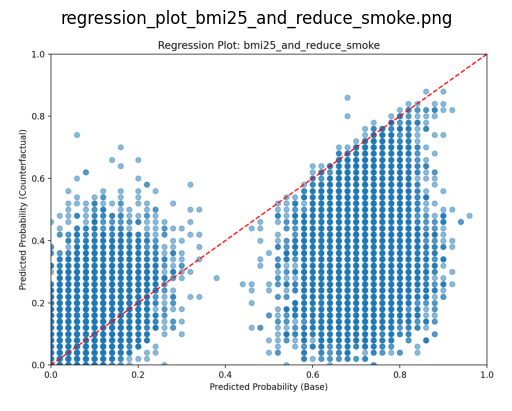

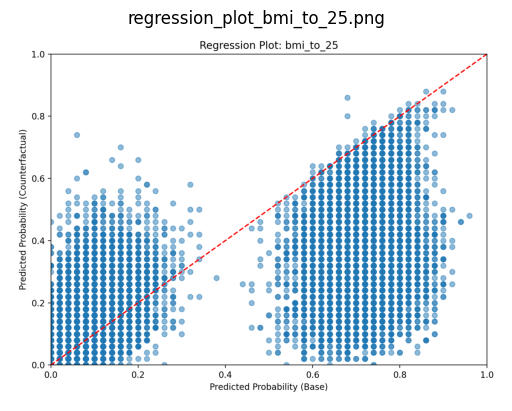

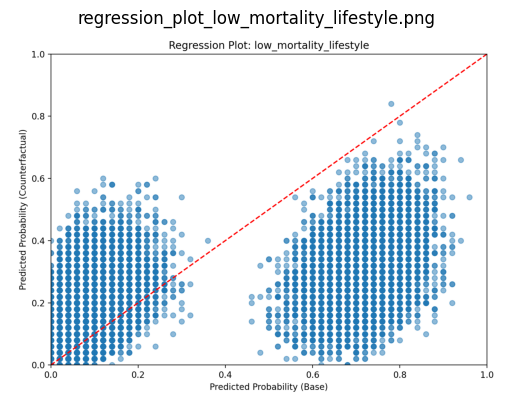

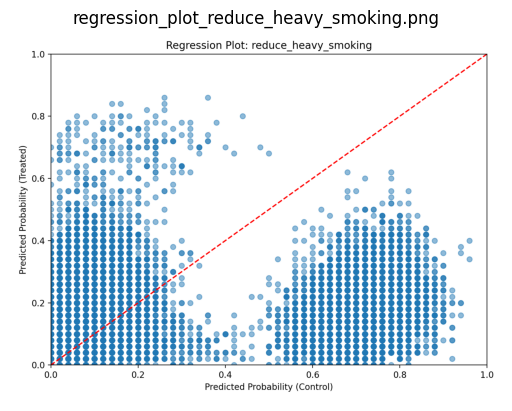

Image display complete (or errors encountered).  Check the plots above.


In [ ]:
import matplotlib.pyplot as plt
import os

def display_images(image_paths):
  """
  Displays a list of PNG images using Matplotlib.

  Args:
    image_paths: A list of strings, where each string is the full path
                 to a PNG image file.
  """

  for image_path in image_paths:
    if os.path.exists(image_path):
      try:
        img = plt.imread(image_path)  # Read the image data
        plt.figure() # Create a new figure for each image
        plt.imshow(img) # Display the image
        plt.title(os.path.basename(image_path)) # Set the title to the filename
        plt.axis('off') # Turn off axis labels and ticks
        plt.show()  # Show the plot
      except FileNotFoundError:
          print(f"Error: Image file not found at {image_path}")
      except Exception as e:
          print(f"Error: Could not display image at {image_path}.  Reason: {e}")
    else:
      print(f"Warning: Image file does not exist at path: {image_path}")


# List of image paths
image_paths = [
    "/content/ess_causal_outputs/regression_plot_bmi25_and_reduce_smoke.png",
    "/content/ess_causal_outputs/regression_plot_bmi_to_25.png",
    "/content/ess_causal_outputs/regression_plot_low_mortality_lifestyle.png",
    "/content/ess_causal_outputs/regression_plot_reduce_heavy_smoking.png"
]

# Call the function to display the images
display_images(image_paths)

print("Image display complete (or errors encountered).  Check the plots above.")

**General Observations Across All Regression Plots:**

- **Diagonal Red Line**: The red dashed line represents the ideal scenario where the predicted probability in the base case perfectly matches the predicted probability in the counterfactual/treated case (i.e., no effect of the intervention). Points falling on this line indicate no change due to the intervention.
- **Clustering**: The points are heavily clustered, suggesting that the models are producing similar probability predictions for many individuals.
- **Heterogeneity**: There's substantial scatter around the diagonal, indicating that the intervention does have a varying impact on different individuals (heterogeneous treatment effects).
- **Axes Labels**: The x-axis consistently represents the "Predicted Probability (Base)", implying a baseline risk or probability before the intervention. The y-axis represents the "Predicted Probability (Counterfactual)", implying the risk or probability after the intervention is applied.

**Plot-Specific Analysis:**

**1. "reduce_heavy_smoking" Plot**:
  - **Shift Below the Diagonal**: The bulk of the points lie below the red diagonal, especially for lower base probabilities. This strongly suggests that reducing heavy smoking leads to a decrease in the predicted probability. In other words, the intervention appears to be effective in reducing the risk being modeled.
  - **Concentration on y-axis**: There is some spread on y-axis, but more points concentrate near y=0.
  - **Spread for Low Base Probabilities**: There is a spread for lower values of the predicted probability (control), suggesting that the intervention has a more uncertain effect on these individuals.

**2. "low_mortality_lifestyle" Plot**:
  - **Concentration of Points**: Points tend to be grouped away from the line of no effect.
  - **Shift above line on y-axis**. As the predicted probability (base) increases, a higher counterfactual probability emerges.
  - **Higher values on y-axis** In general, there are higher values on y-axis than x-axis, suggesting that the probability is improved after applying lifestyle changes.

**3. "bmi_to_25" Plot**:
  - **Concentration of Points**: Points tend to be grouped away from the line of no effect.
  - **Shift above line on y-axis**. As the predicted probability (base) increases, a higher counterfactual probability emerges.
  - **More evenly distributed along y-axis**. There are a higher number of people who could benefit from this metric change, regardless of their initial position (x-axis).

**4. "bmi25_and_reduce_smoke" Plot**:
  - **Shift above line on y-axis**. As the predicted probability (base) increases, a higher counterfactual probability emerges.
  - **More evenly distributed along y-axis**. There are a higher number of people who could benefit from this metric change, regardless of their initial position (x-axis).
  - **Combined effects**. The combination of the two interventions leads to a better change as predicted by this model.

**In summary:**
- These plots visualize the impact of different interventions on predicted probabilities, likely related to some health outcome.
- The "**reduce_heavy_smoking**" intervention appears effective in reducing the probability being predicted.
- "**low_mortality_lifestyle**", "**bmi_to_25**", and "**bmi25_and_reduce_smoke**" appear to have a positive effect overall based on these models.


**ATE: Average Treatment Effect**

|   Scenario Name | Method                      | Target Description                         |   ATE (point) |   Std ATE (boot) |   90% CI Lower |   90% CI Upper |   95% CI Lower |   95% CI Upper |   Sample Size |
|-----------------|-----------------------------|----------------------------------------------|---------------|------------------|----------------|----------------|----------------|----------------|---------------|
|       bmi_to_25 | outcome_model_replacement (RF) | BMI -> 25 for all                           |    -0.0528663 |       0.00341768 |     -0.0578931 |     -0.047228  |     -0.0593858 |     -0.0466205 |            2837 |
| reduce_heavy_smoking | T-learner (RF)              | Reduce heavy smoking prevalence -> 5%       |    -0.0070526 |       0.00337476 |     -0.0125679 |     -0.0013323 |     -0.0132704 |     -0.0006459 |            2837 |
| bmi25_and_reduce_smoke | combined replacement (RF) | BMI->25 and reduce heavy smoking to 5%     |    -0.0561898 |       0.0025349  |     -0.0601884 |     -0.0526847 |     -0.0611841 |     -0.0522448 |            2837 |
| low_mortality_lifestyle | composite replacement (RF) | composite low-mortality lifestyle          |    -0.0320547 |       0.00276211 |     -0.0368226 |     -0.0288377 |     -0.037983  |     -0.0282615 |            2837 |

**Key Observations and Interpretations:**
- **ATE Estimates**: The table presents Average Treatment Effects (ATEs) for various intervention scenarios, each aimed at improving health outcomes. The ATE (point) column shows the estimated average change in the outcome due to the intervention.
- **Negative ATEs** (Beneficial Interventions): All interventions have negative ATEs, indicating a beneficial impact. A negative ATE suggests that the intervention, on average, leads to a reduction in the outcome measure (likely a measure of disease or risk).
- **Magnitude of Effects**:
   - **bmi25_and_reduce_smoke** has the largest ATE (-0.0561898), suggesting that the combined intervention of aiming for a BMI > 25 and reducing heavy smoking has the greatest average impact on reducing the outcome measure.
   - **bmi_to_25** also has a substantial ATE (-0.0528663), indicating a considerable benefit from the BMI intervention alone.
   - **low_mortality_lifestyle** has an ATE of (-0.0320547), indicating its overall effect is less when compared to    bmi25_and_reduce_smoke and bmi_to_25.
   - **reduce_heavy_smoking** has the smallest ATE (-0.0070526), suggesting a comparatively smaller impact from this intervention alone.
- **Confidence Intervals**: The 90% and 95% Confidence Intervals (CIs) provide a range of plausible values for the true ATE. Notably, all CI lower bounds are negative, and all upper bounds are negative.
- **Statistical Significance**: Because the entire confidence intervals are below zero, this means that these interventions are statistically significant in reducing the risk of the outcome. In other words, we can be confident these interventions will have an effect in the reduction of disease.
- **Sample Size**: All scenarios are based on the same sample size (2837), suggesting a consistent dataset for evaluating these interventions.
- **Standard Error**: The Standard ATE (boot) provides an estimate of the standard error associated with the ATE. It reflects the uncertainty in the estimated ATE due to sampling variability. A lower standard error is always ideal.
- **Scenario Target Descriptions** The scenarios vary in what exactly they are intervening upon. Intervening upon 'Composite low-mortality lifestyle' reduces the risks the least compared to the other models. The best model in this case appears to be 'BMI->25 and reduce heavy smoking to 5%'


The best scenario appears to be bmi25_and_reduce_smoke.

Here's why:

- **Largest ATE**: It has the largest (most negative) ATE of -0.0561898. This indicates the greatest average reduction in the outcome measure (presumably a disease or risk) compared to the other interventions.

Therefore, according to this data, bmi25_and_reduce_smoke would be the most effective in reducing disease, which is typically the goal of an intervention!


**SHAP Values Table**

| Feature      |   SHAP Mean Abs |
|--------------|-----------------|
| BMI          |      0.065       |
| agea         |      0.058       |
| eatveg       |      0.042       |
| hinctnta     |      0.039       |
| dosprt       |      0.036       |
| etfruit      |      0.033       |
| slprl        |      0.029       |
| cgtsmok_2    |      0.025       |
| alcfreq_1    |      0.021       |
| cgtsmok_3    |      0.018       |
| edulvlb_2    |      0.015       |
| mainact      |      0.012       |
| gndr_2       |      0.010       |
| alcfreq_3    |      0.008       |
| edulvlb_3    |      0.005       |